<a href="https://colab.research.google.com/github/tohpedo/wikibot/blob/main/transformers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
#install depedencies hugging face
!pip install pytorch-pretrained-bert pytorch-nlp pytorch_transformers
!pip install folium


In [5]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [6]:

import tensorflow as tf
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from pytorch_transformers import BertTokenizer, BertConfig, BertModel
from pytorch_transformers import AdamW, BertForQuestionAnswering
from tqdm import tqdm, trange
import pandas as pd
import io
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


In [7]:
!wget 'https://raw.githubusercontent.com/nlpyang/pytorch-transformers/master/examples/utils_squad.py'
!wget 'https://raw.githubusercontent.com/nlpyang/pytorch-transformers/master/examples/utils_squad_evaluate.py'

from utils_squad import (read_squad_examples, convert_examples_to_features,
                         RawResult, write_predictions,
                         RawResultExtended, write_predictions_extended)
from utils_squad_evaluate import EVAL_OPTS, main as evaluate_on_squad, plot_pr_curve

--2021-11-01 18:42:57--  https://raw.githubusercontent.com/nlpyang/pytorch-transformers/master/examples/utils_squad.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 41529 (41K) [text/plain]
Saving to: ‘utils_squad.py.2’

utils_squad.py.2    100%[===================>]  40.56K  --.-KB/s    in 0.004s  

2021-11-01 18:42:57 (11.1 MB/s) - ‘utils_squad.py.2’ saved [41529/41529]

--2021-11-01 18:42:57--  https://raw.githubusercontent.com/nlpyang/pytorch-transformers/master/examples/utils_squad_evaluate.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response.

In [34]:
from google.colab import drive
drive.mount('/content/drive/')
!ls

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
content      utils_squad_evaluate.py	utils_squad.py.1
drive	     utils_squad_evaluate.py.1	utils_squad.py.2
__pycache__  utils_squad_evaluate.py.2
sample_data  utils_squad.py


In [9]:
input_file = '/content/drive/My Drive/train-v2.0.json'
examples = read_squad_examples(input_file=input_file,
                                is_training=True,
                                version_2_with_negative=True)

In [10]:
examples = examples[:1000]

In [11]:
train_data = pd.DataFrame.from_records([vars(example) for example in examples])
train_data.head()

,qas_id,question_text,doc_tokens,orig_answer_text,start_position,end_position,is_impossible
0,56be85543aeaaa14008c9063,When did Beyonce start becoming popular?,"[Beyoncé, Giselle, Knowles-Carter, (/biːˈjɒnse...",in the late 1990s,39,42,False
1,56be85543aeaaa14008c9065,What areas did Beyonce compete in when she was...,"[Beyoncé, Giselle, Knowles-Carter, (/biːˈjɒnse...",singing and dancing,28,30,False
2,56be85543aeaaa14008c9066,When did Beyonce leave Destiny's Child and bec...,"[Beyoncé, Giselle, Knowles-Carter, (/biːˈjɒnse...",2003,82,82,False
3,56bf6b0f3aeaaa14008c9601,In what city and state did Beyonce grow up?,"[Beyoncé, Giselle, Knowles-Carter, (/biːˈjɒnse...","Houston, Texas",22,23,False
4,56bf6b0f3aeaaa14008c9602,In which decade did Beyonce become famous?,"[Beyoncé, Giselle, Knowles-Carter, (/biːˈjɒnse...",late 1990s,41,42,False


In [12]:
#get all questions from one article
sample = train_data.sample(frac=1).head(1)
print(sample)
context = sample.doc_tokens.values
print(context)
train_data[train_data.doc_tokens.values==context]


                       qas_id  ... is_impossible
178  56bf97aba10cfb140055119e  ...         False

[1 rows x 7 columns]
[list(['On', 'April', '4,', '2008,', 'Beyoncé', 'married', 'Jay', 'Z.', 'She', 'publicly', 'revealed', 'their', 'marriage', 'in', 'a', 'video', 'montage', 'at', 'the', 'listening', 'party', 'for', 'her', 'third', 'studio', 'album,', 'I', 'Am...', 'Sasha', 'Fierce,', 'in', "Manhattan's", 'Sony', 'Club', 'on', 'October', '22,', '2008.', 'I', 'Am...', 'Sasha', 'Fierce', 'was', 'released', 'on', 'November', '18,', '2008', 'in', 'the', 'United', 'States.', 'The', 'album', 'formally', 'introduces', "Beyoncé's", 'alter', 'ego', 'Sasha', 'Fierce,', 'conceived', 'during', 'the', 'making', 'of', 'her', '2003', 'single', '"Crazy', 'in', 'Love",', 'selling', '482,000', 'copies', 'in', 'its', 'first', 'week,', 'debuting', 'atop', 'the', 'Billboard', '200,', 'and', 'giving', 'Beyoncé', 'her', 'third', 'consecutive', 'number-one', 'album', 'in', 'the', 'US.', 'The', 'album', 'featur

,qas_id,question_text,doc_tokens,orig_answer_text,start_position,end_position,is_impossible
173,56be95823aeaaa14008c910c,Beyonce got married in 2008 to whom?,"[On, April, 4,, 2008,, Beyoncé, married, Jay, ...",Jay Z,6,7,False
174,56be95823aeaaa14008c910d,"Her third album, ""I am...Sasha Fierce"" was rel...","[On, April, 4,, 2008,, Beyoncé, married, Jay, ...","November 18, 2008",45,47,False
175,56be95823aeaaa14008c910e,"For which decade, did Beyonce have more top te...","[On, April, 4,, 2008,, Beyoncé, married, Jay, ...",2000s,152,152,False
176,56be95823aeaaa14008c910f,Which singer beat out Beyonce for best video p...,"[On, April, 4,, 2008,, Beyoncé, married, Jay, ...",Taylor Swift,262,263,False
177,56be95823aeaaa14008c9110,"In 2009, Beyonce started her second world tour...","[On, April, 4,, 2008,, Beyoncé, married, Jay, ...",119.5 million,310,311,False
178,56bf97aba10cfb140055119e,How did she reveal the marriage?,"[On, April, 4,, 2008,, Beyoncé, married, Jay, ...",in a video montage,13,16,False
179,56bf97aba10cfb140055119f,When did Beyonce begin her second world tour?,"[On, April, 4,, 2008,, Beyoncé, married, Jay, ...",March 2009,289,290,False
180,56bf97aba10cfb14005511a0,Who beat out Beyonce for Best Female Video ?,"[On, April, 4,, 2008,, Beyoncé, married, Jay, ...",Taylor Swift,262,263,False
181,56bf97aba10cfb14005511a1,How much did the second world tour make in dol...,"[On, April, 4,, 2008,, Beyoncé, married, Jay, ...",119.5 million,310,311,False
182,56d4bf242ccc5a1400d831be,When did Beyoncé get married?,"[On, April, 4,, 2008,, Beyoncé, married, Jay, ...","April 4, 2008",1,3,False


In [13]:
import random
def print_squad_sample(train_data, line_length=14, separator_length=120):
  sample = train_data.sample(frac=1).head(1)
  context = sample.doc_tokens.values
  print('='*separator_length)
  print('CONTEXT: ')
  print('='*separator_length)
  lines = [' '.join(context[0][idx:idx+line_length]) for idx in range(0, len(context[0]), line_length)]
  for l in lines:
      print(l)
  print('='*separator_length)
  questions = train_data[train_data.doc_tokens.values==context]
  print('QUESTION:', ' '*(3*separator_length//4), 'ANSWER:')
  for idx, row in questions.iterrows():
    question = row.question_text
    answer = row.orig_answer_text
    print(question, ' '*(3*separator_length//4-len(question)+9), (answer if answer else 'No awnser found'))

In [14]:
print_squad_sample(train_data)

CONTEXT: 
All of Chopin's compositions include the piano. Most are for solo piano, though he
also wrote two piano concertos, a few chamber pieces, and some songs to Polish
lyrics. His keyboard style is highly individual and often technically demanding; his own performances
were noted for their nuance and sensitivity. Chopin invented the concept of instrumental ballade.
His major piano works also include mazurkas, waltzes, nocturnes, polonaises, études, impromptus, scherzos, preludes
and sonatas, some published only after his death. Influences on his compositional style include
Polish folk music, the classical tradition of J. S. Bach, Mozart and Schubert, the
music of all of whom he admired, as well as the Paris salons where
he was a frequent guest. His innovations in style, musical form, and harmony, and
his association of music with nationalism, were influential throughout and after the late Romantic
period.
QUESTION:                                                                    

In [15]:
train_data['paragraph_len'] = train_data['doc_tokens'].apply(len)
train_data['question_len'] = train_data['question_text'].apply(len)
train_data.sample(frac=1).head(5)

,qas_id,question_text,doc_tokens,orig_answer_text,start_position,end_position,is_impossible,paragraph_len,question_len
672,56d4efd92ccc5a1400d83379,When was the disagreement settled out of court?,"[The, release, of, a, video-game, Starpower:, ...",June 2013,46,47,False,78,47
721,56d4f71e2ccc5a1400d833aa,What type of clothing does the British partner...,"[In, October, 2014,, Beyoncé, signed, a, deal,...",activewear,10,10,False,50,69
346,56d4d18d2ccc5a1400d8325a,How many people watched the 2011 MTV Video Mus...,"[In, August,, the, couple, attended, the, 2011...",12.4 million,91,92,False,133,56
178,56bf97aba10cfb140055119e,How did she reveal the marriage?,"[On, April, 4,, 2008,, Beyoncé, married, Jay, ...",in a video montage,13,16,False,312,32
455,56beba293aeaaa14008c92f0,How old was Beyonce when she went to her first...,"[Beyoncé, names, Michael, Jackson, as, her, ma...",five,10,10,False,127,80


In [16]:
max_seq_length = 256
print("Percentage of context's less than max_seq_length = %s%%" % (len([l for l in train_data['paragraph_len'] if l <= max_seq_length])/len(train_data) * 100))

Percentage of context's less than max_seq_length = 95.1%


In [17]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [18]:
doc_stride = 128
max_seq_length = 256
max_query_length = 64
# batch size of 64 if RAM available.
batch_size = 8


In [19]:

cached_features_file = '/content/drive/My Drive/cache_train'

if not os.path.exists(cached_features_file):
  features = convert_examples_to_features(examples=examples,
                                        tokenizer=tokenizer,
                                        max_seq_length=max_seq_length,
                                        doc_stride=doc_stride,
                                        max_query_length=max_query_length,
                                        is_training=True)
  torch.save(features, cached_features_file)
else:
  features = torch.load(cached_features_file)

In [20]:
 #set seeds
np.random.seed(1234)
torch.manual_seed(1234)

In [21]:
# Convert to Tensors and build dataset
all_input_ids = torch.tensor([f.input_ids for f in features], dtype=torch.long)
all_input_mask = torch.tensor([f.input_mask for f in features], dtype=torch.long)
all_segment_ids = torch.tensor([f.segment_ids for f in features], dtype=torch.long)
all_cls_index = torch.tensor([f.cls_index for f in features], dtype=torch.long)
all_p_mask = torch.tensor([f.p_mask for f in features], dtype=torch.float)

all_start_positions = torch.tensor([f.start_position for f in features], dtype=torch.long)
all_end_positions = torch.tensor([f.end_position for f in features], dtype=torch.long)
dataset = TensorDataset(all_input_ids, all_input_mask, all_segment_ids,
                        all_start_positions, all_end_positions,
                        all_cls_index, all_p_mask)

In [22]:
train_sampler = RandomSampler(dataset)
train_dataloader = DataLoader(dataset, sampler=train_sampler, batch_size=batch_size, drop_last=True)

In [23]:
def to_list(tensor):
    return tensor.detach().cpu().tolist()

In [24]:
import glob
checkpoints = sorted(glob.glob('/content/drive/My Drive/checkpoint*-[0-9]*'))

In [25]:
if len(checkpoints) > 0:
  global_step = checkpoints[-1].split('-')[-1]
  ckpt_name = '/drive/My Drive/Medium/checkpoint-{}'.format(global_step)
  print("Loading model from checkpoint %s" % ckpt_name)
  model = BertForQuestionAnswering.from_pretrained(ckpt_name)
  train_loss_set_ckpt = torch.load(ckpt_name + '/training_loss.pt')
  train_loss_set = to_list(train_loss_set_ckpt)
  tr_loss = train_loss_set[-1]
else:
  global_step = 0
  train_loss_set = []
  tr_loss = 0.0
  model = BertForQuestionAnswering.from_pretrained('bert-base-uncased')

model.cuda()

BertForQuestionAnswering(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_

In [26]:
param_optimizer = list(model.named_parameters())
print(param_optimizer[-2])
print(param_optimizer[-1])

('qa_outputs.weight', Parameter containing:
tensor([[-0.0231, -0.0370, -0.0441,  ...,  0.0076, -0.0057,  0.0081],
        [ 0.0022,  0.0065,  0.0223,  ..., -0.0018,  0.0032, -0.0065]],
       device='cuda:0', requires_grad=True))
('qa_outputs.bias', Parameter containing:
tensor([0., 0.], device='cuda:0', requires_grad=True))


In [27]:
learning_rate = 5e-5
adam_epsilon=1e-8
no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
    ]
optimizer = AdamW(optimizer_grouped_parameters, lr=learning_rate, eps=adam_epsilon)

In [28]:
num_train_epochs = 1

# specify GPU device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

print("***** Running training *****")
print("  Num examples = %d" % len(dataset))
print("  Num Epochs = %d" % num_train_epochs)
print("  Batch size = %d" % batch_size)
print("  Total optimization steps = %d" % (len(train_dataloader) // num_train_epochs))

model.zero_grad()
train_iterator = trange(num_train_epochs, desc="Epoch")

for _ in train_iterator:
    epoch_iterator = tqdm(train_dataloader, desc="Iteration")
    for step, batch in enumerate(epoch_iterator):
      if step < global_step + 1:
        continue

      model.train()
      batch = tuple(t.to(device) for t in batch)

      inputs = {'input_ids':       batch[0],
                'attention_mask':  batch[1], 
                'token_type_ids':  batch[2],  
                'start_positions': batch[3], 
                'end_positions':   batch[4]}

      outputs = model(**inputs)

      loss = outputs[0]
      train_loss_set.append(loss)
      loss.backward()
      torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

      tr_loss += loss.item()
      optimizer.step()
      model.zero_grad()
      global_step += 1
    
      if global_step % 1000 == 0:
        print("Train loss: {}".format(tr_loss/global_step))
        output_dir = '/drive/My Drive/Medium/checkpoint-{}'.format(global_step)
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)
        model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
        model_to_save.save_pretrained(output_dir)
        torch.save(torch.tensor(train_loss_set), os.path.join(output_dir, 'training_loss.pt'))
        print("Saving model checkpoint to %s" % output_dir)

***** Running training *****
  Num examples = 1202
  Num Epochs = 1
  Batch size = 8
  Total optimization steps = 150


Iteration:   0%|          | 0/150 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/pytorch_transformers/optimization.py:166: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:1025.)
  exp_avg.mul_(beta1).add_(1.0 - beta1, grad)

Epoch: 100%|██████████| 1/1 [02:08<00:00, 128.83s/it]


In [29]:
output_dir = 'content/drive/My Drive/checkpoint-final'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
model_to_save = model.module if hasattr(model, 'module') else model
model_to_save.save_pretrained(output_dir)

In [30]:
train_loss_set_ckpt = torch.load('content/drive/My Drive/checkpoint-final/training_loss.pt')
train_loss_set = to_list(train_loss_set_ckpt)

FileNotFoundError: ignored

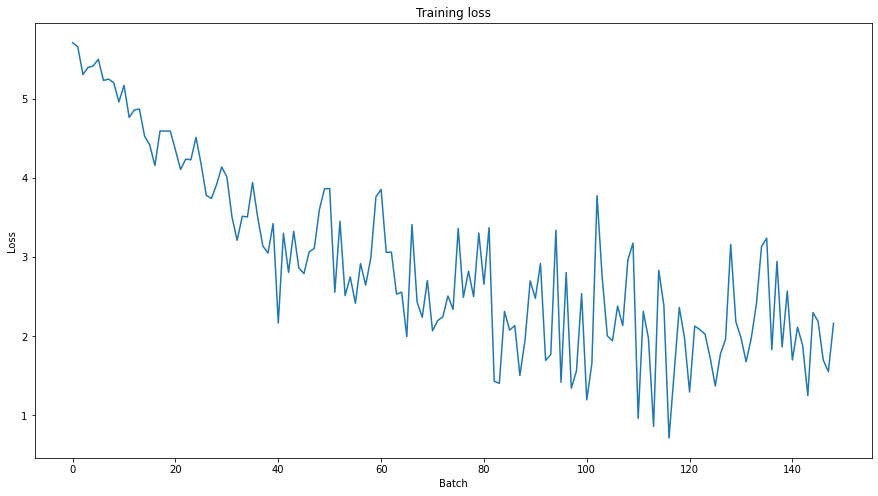

In [31]:
plt.figure(figsize=(15,8))
plt.title("Training loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.plot(train_loss_set)
plt.show()

In [39]:
input_file = '/content/drive/My Drive/dev-v2.0.json'
val_examples = read_squad_examples(input_file=input_file,
                                is_training=False,
                                version_2_with_negative=True
                                )

doc_stride = 128
max_seq_length = 256
max_query_length = 64
cached_features_file = '/content/drive/My Drive/cache_validation'


# Cache features for faster loading
if not os.path.exists(cached_features_file):
  features = convert_examples_to_features(examples=val_examples,
                                        tokenizer=tokenizer,
                                        max_seq_length=max_seq_length,
                                        doc_stride=doc_stride,
                                        max_query_length=max_query_length,
                                        is_training=False)
  torch.save(features, cached_features_file)
else:
  features = torch.load(cached_features_file)

In [40]:
# Convert to Tensors and build dataset
all_input_ids = torch.tensor([f.input_ids for f in features], dtype=torch.long)
all_input_mask = torch.tensor([f.input_mask for f in features], dtype=torch.long)
all_segment_ids = torch.tensor([f.segment_ids for f in features], dtype=torch.long)
all_cls_index = torch.tensor([f.cls_index for f in features], dtype=torch.long)
all_p_mask = torch.tensor([f.p_mask for f in features], dtype=torch.float)

all_example_index = torch.arange(all_input_ids.size(0), dtype=torch.long)
dataset = TensorDataset(all_input_ids, all_input_mask, all_segment_ids,
                        all_example_index, all_cls_index, all_p_mask)

In [41]:
validation_sampler = SequentialSampler(dataset)
validation_dataloader = DataLoader(dataset, sampler=validation_sampler, batch_size=batch_size, drop_last=True)

In [44]:
def evaluate(model, tokenizer):
  print("***** Running evaluation *****")
  print("  Num examples = %d" % len(dataset))
  print("  Batch size = %d" % batch_size)
  all_results = []
  predict_file = '/content/drive/My Drive/dev-v2.0.json'
  for batch in tqdm(validation_dataloader, desc="Evaluating", miniters=100, mininterval=5.0):
    model.eval()
    batch = tuple(t.to(device) for t in batch)
    with torch.no_grad():
      inputs = {'input_ids':      batch[0],
                'attention_mask': batch[1],
                'token_type_ids': batch[2]
                }
      example_indices = batch[3]
      outputs = model(**inputs)

    for i, example_index in enumerate(example_indices):
      eval_feature = features[example_index.item()]
      unique_id = int(eval_feature.unique_id)

      result = RawResult(unique_id    = unique_id,
                         start_logits = to_list(outputs[0][i]),
                         end_logits   = to_list(outputs[1][i]))
      all_results.append(result)

  # Compute predictions
  output_prediction_file = "/content/drive/My Drive/predictions.json"
  output_nbest_file = "/content/drive/My Drive/nbest_predictions.json"
  output_null_log_odds_file = "/content/drive/My Drive/null_odds.json"
  output_dir = "/content/drive/My Drive/predict_results"

  write_predictions(val_examples, features, all_results, 10,
                  30, True, output_prediction_file,
                  output_nbest_file, output_null_log_odds_file, False,
                  True, 0.0)

  # Evaluate with the official SQuAD script
  evaluate_options = EVAL_OPTS(data_file=predict_file,
                               pred_file=output_prediction_file,
                               na_prob_file=output_null_log_odds_file,
                               out_image_dir=None)
  results = evaluate_on_squad(evaluate_options)
  return results

In [45]:
results = evaluate(model, tokenizer)

***** Running evaluation *****
  Num examples = 13600
  Batch size = 8


Evaluating: 100%|██████████| 1700/1700 [07:38<00:00,  3.71it/s]


{
  "exact": 19.093742103933295,
  "f1": 25.240302484276327,
  "total": 11873,
  "HasAns_exact": 38.006072874493924,
  "HasAns_f1": 50.31682041089959,
  "HasAns_total": 5928,
  "NoAns_exact": 0.23549201009251472,
  "NoAns_f1": 0.23549201009251472,
  "NoAns_total": 5945,
  "best_exact": 50.33268761054494,
  "best_exact_thresh": -15.151115000247955,
  "best_f1": 50.455844184582034,
  "best_f1_thresh": -15.151115000247955
}
